In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
from sklearn import datasets, linear_model, model_selection
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib #as mpl

np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]


## settings
# min_days: only use counties which have data for the last min_days
# max_frac_missing: after filtering by min_days, only keep features with at most max_frac_missing
# is_pop_scale: whether to scale cases by population

min_days = 0  #28
max_frac_missing = 0.1
is_pop_scale = False
# TODO add option to predict log and change from week to week with linear models

## Load data into pd dataframes ##

# nyt case and death counts, where each date-county pair is a row
nyt_counts_df = pd.read_csv('data/nyt-us-counties-cases-deaths.csv') # must remove non-ascii
nyt_counts_df['date'] = pd.to_datetime(nyt_counts_df['date'])

# contains ordinal dates (t=1 on jan 1, 0001)
interventions_df = pd.read_csv('data/jieyingwu_dates_interventions.csv')

# ex/ pop size, income, urban/rural, temperature, public transit score, doctors per 1000 people
demographics_df = pd.read_csv('data/jieyingwu_demographics_counties.csv') 


# make pivot df where each county is a row, with dates as columns
cases_df = pd.pivot_table(nyt_counts_df, values = 'cases', index=['fips','county','state'], columns = 'date').reset_index()
deaths_df = pd.pivot_table(nyt_counts_df, values = 'deaths', index=['fips','county','state'], columns = 'date').reset_index()


# merge in additional features (case/death counts will be rightmost columns)
# first 3 cols will be fips, county, state
cases_df = interventions_df.merge(cases_df, left_on='FIPS', right_on='fips', suffixes=('_interventions', '_cases')) 
cases_df = demographics_df.merge(cases_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 

deaths_df = interventions_df.merge(deaths_df, left_on='FIPS', right_on='fips',suffixes=('_interventions', '_deaths')) 
deaths_df = demographics_df.merge(deaths_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 


####### rest of code uses cases only for now

## filter counties and features with missing data

# which cols in cases_df are counts
counts_mask = [str(c)[:5] == '2020-' for c in cases_df.columns]

if is_pop_scale:
    cases_df.iloc[:,counts_mask] = np.divide(1.0*cases_df.iloc[:,counts_mask].values, cases_df['POP_ESTIMATE_2018'].values[:,None])

    
# keep counties which have data from past 28 (or 0, etc) days
end = pd.to_datetime('2020-04-13 00:00:00') # could figure out days automatically from last col name
start = end - pd.DateOffset(min_days)
cases_df = cases_df[~cases_df.loc[:,start:end].isna().any(axis=1)]



# extract numeric columns as features (for demographics and intervention, only exclude county/state name)
# remove fips, which is technically numeric (TODO check for other such cols)
not_fips_mask = [str(c).lower() != 'fips' for c in cases_df.columns]
features_target_df = cases_df.loc[:,not_fips_mask]
features_target_df = features_target_df.select_dtypes(include='number') # numeric features only

# keep columns which are >10% missing (lose a lot of prev dates if not filtering counties first)
keep_cols = features_target_df.columns[features_target_df.isnull().mean() < max_frac_missing]
features_target_df = features_target_df[keep_cols]

#print(features_target_df.columns)
print(features_target_df.shape, cases_df.shape)


# TODO can replace features_target_df with x_df and y variables only, filter X_df

(2663, 261) (2663, 444)


In [9]:
# try linear model using prev counts in same county (whatever days left after filtering)



# note: x is array of features, will correspond to 'data'. TODO if dtype is object, x may be list
# y is array 'target'
# TODO make 'labels' descriptions from features_target_df.columns[...] and fips/county/state cols

end = pd.to_datetime('2020-04-12 00:00:00') # pd slicing includes last index
x_df = features_target_df.loc[:, :end]
counts_mask = [str(c)[:5] == '2020-' for c in x_df.columns]
x_df = x_df.iloc[:,counts_mask]
x = x_df.values 
y = features_target_df.iloc[:,-1].values # last day
y = y.reshape((-1,1))

# mask counties with missing values
# can also mask counties w missing y here
mask = ~np.isnan(x).any(axis=1) & ~np.isinf(x).any(axis=1) & ~np.isneginf(x).any(axis=1) 


regr = linear_model.LinearRegression() 
regr.fit(x[mask], y[mask])

#preds = regr.predict(test_data)



def printTopCoefs(values, columns, nTop=None, includeBottom=False, maxPad=80):
    '''given values and corresponding descriptions in order, print top values'''
    col_valuesL = list( zip(list(columns), values.flatten().tolist()) )
    col_valuesL.sort(key=lambda tup: abs(tup[1]), reverse=True)

    p = max( [len(str(c)) for c in columns] ) + 1 # padding for print
    p = min(p, maxPad)
    if nTop == None:
        nTop = len(columns)
    for col, effect in col_valuesL[:nTop]:
        print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    if includeBottom and nTop*2 > len(columns): 
        # print remaining entries without duplicates
        for col, effect in col_valuesL[nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    elif includeBottom:
        print('...')
        for col, effect in col_valuesL[-nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )        
    return


# print top coefficients - as expected, prev day has biggest effect
print('# Linear model on log(cases), using previous days counts (Apr 5 to Apr 12)')
printTopCoefs(regr.coef_, x_df.columns, nTop=10, includeBottom=True)



# Linear model on log(cases), using previous days counts (Apr 5 to Apr 12)
2020-04-12 00:00:00 	   1.19075
2020-04-05 00:00:00 	  -0.36972
2020-04-06 00:00:00 	   0.30168
2020-04-09 00:00:00 	  -0.29756
2020-04-08 00:00:00 	   0.29135
2020-04-10 00:00:00 	  -0.16355
2020-04-11 00:00:00 	   0.12606
2020-04-07 00:00:00 	  -0.10301


In [10]:

## linear model: log(cases) against demographics, interventions, and counts in same county on previous days
# remake x_df to include these additional features
end = pd.to_datetime('2020-04-12 00:00:00') # pd slicing includes last index
x_df = features_target_df.loc[:, :end]
x = x_df.values
y = features_target_df.iloc[:,-1].values # last day
y = y.reshape((-1,1))

# mask counties with missing values
# can also mask counties w missing y here
mask = ~np.isnan(x).any(axis=1) & ~np.isinf(x).any(axis=1) & ~np.isneginf(x).any(axis=1) 


regr = linear_model.LinearRegression() 
regr.fit(x[mask], y[mask])

#preds = regr.predict(test_data)
print('# Linear model of log(cases) using demographics, interventions, previous days counts')
printTopCoefs(regr.coef_, x_df.columns, nTop=10, includeBottom=True)

# clearly overfitting 
# ex/ top 3 coefficients area


# Linear model of log(cases) using demographics, interventions, previous days counts
Area in square miles - Water area                                               	 -51.06426
Area in square miles - Total area                                               	  51.06323
Area in square miles - Land area                                                	 -51.06305
Fraction of Active Physicians Who Are Age 60 or Older 2018 (AAMC)               	  38.91585
Fraction of Residents in ACGME Programs Who Are IMGs as of December 31 2018 (AAMC)	  34.12244
Fraction of Active Physicians Who Are International Medical Graduates (IMGs) 2018 (AAMC)	 -33.41748
Fraction of Active Physicians Who Are Female 2018 (AAMC)                        	  20.42879
Fraction of Physicians Retained in State from Undergraduate Medical Education (UME) 2018 (AAMC)	   9.73328
Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)          	   7.07774
Active General Surgeons per 100000 Population 2018 (AAMC)     

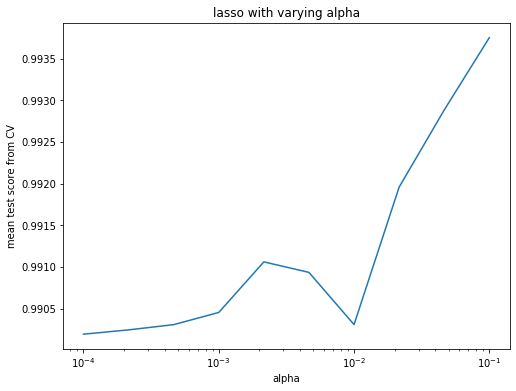

In [11]:
# try lasso
# choose alpha with cv (takes a few min, doesn't converge within 1000 iter)
# note: faster if random selecting coef to update, but less smooth. alpha = 1 was still best

regr = linear_model.Lasso(alpha=1.0, max_iter=5000,selection='cyclic')

alphas = np.logspace(-4, -1, 10)
tuned_parameters = [{'alpha': alphas}]
n_folds = 4

clf = model_selection.GridSearchCV(regr, tuned_parameters, cv=n_folds, refit=False)
clf.fit(x[mask], y[mask])
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize=(8,6))
plt.semilogx(alphas, scores)
ax.set_title('lasso with varying alpha')
ax.set_ylabel('mean test score from CV')
ax.set_xlabel('alpha')
plt.show()  


In [12]:
# lasso, continued



# highest test score was at alpha = 1
# compare small, large alpha, and positive only

regr = linear_model.Lasso(alpha=1.0,max_iter=5000)
regr.fit(x[mask], y[mask])
print('\n# Lasso with alpha = 1.0 (all L1 penalty)')
printTopCoefs(regr.coef_, x_df.columns, nTop=10, includeBottom=False)


regr = linear_model.Lasso(alpha=1.0, max_iter=5000, positive=True)
regr.fit(x[mask], y[mask])
print('\n# Lasso with alpha = 1.0 and positive restraint')
printTopCoefs(regr.coef_, x_df.columns, nTop=10, includeBottom=False)


regr = linear_model.Lasso(alpha=0.0001, max_iter=5000)
regr.fit(x[mask], y[mask])
print('\n# Lasso with alpha = 0.0001')
printTopCoefs(regr.coef_, x_df.columns, nTop=10, includeBottom=False)


    



# Lasso with alpha = 1.0 (all L1 penalty)
Pediatrics** (AAMC)                                                             	  -1.73005
Cardiovascular Disease (AAMC)                                                   	  -0.73463
Psychiatry (AAMC)                                                               	   0.59162
Pediatrics Primary Care (2019)                                                  	   0.57378
Internal Medicine Primary Care (2019)                                           	   0.48692
2020-04-12 00:00:00                                                             	   0.45675
HNAC_MALE                                                                       	  -0.43575
2020-04-11 00:00:00                                                             	   0.42212
All Other Specialties specialists (2019)                                        	  -0.41070
2020-04-10 00:00:00                                                             	   0.34598

# Lasso with alpha = 1.0 and positiv

5
(79,)
Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=790.535, BIC=804.111, Time=0.026 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=942.548, BIC=947.073, Time=0.004 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=790.970, BIC=797.758, Time=0.013 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=880.867, BIC=887.655, Time=0.017 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=956.321, BIC=958.584, Time=0.003 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=793.394, BIC=804.707, Time=0.023 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=791.525, BIC=802.838, Time=0.023 seconds
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=790.432, BIC=806.271, Time=0.031 seconds
Fit ARIMA: (3, 1, 1)x(

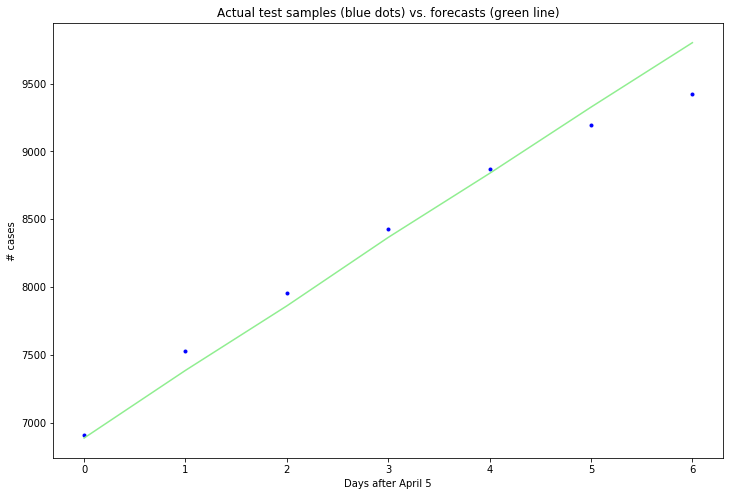

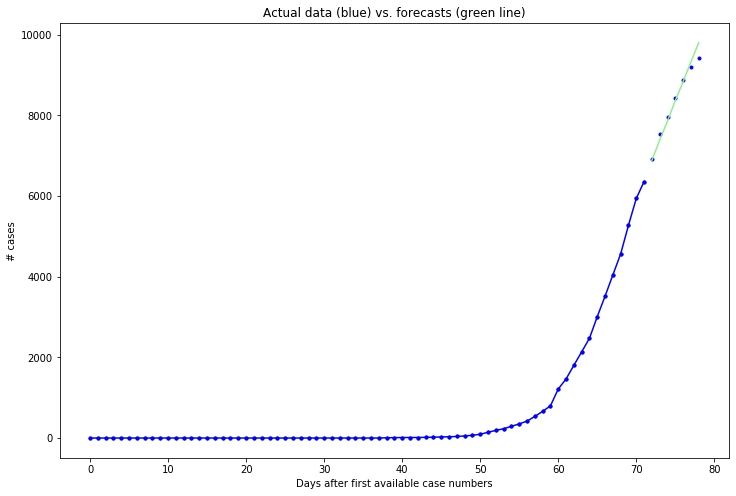

In [68]:

# try pmdarima for arima next
# pyflux abandoned?
# TODO combine arima with OLS? or arimax? 
# https://stats.stackexchange.com/questions/418259/arimax-vs-regression-with-arima-errors


import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt


# Load and fit count data for a single county at a time

i = int(np.where(cases_df['FIPS'] == 6037)[0]) # only do LA for now
counts_mask = [str(c)[:5] == '2020-' for c in cases_df.columns]
data = np.array(cases_df.iloc[i,counts_mask].values, dtype='float')

# provide data starting from first non-missing day
i = np.where(~np.isnan(data))[0][0]
print(i)
data = data[i:]
print(data.shape) # data should be a 1d array of counts over time


train, test = model_selection.train_test_split(data, test_size=7) # test on last week

# fit model -- auto_arima automatically chooses parameters if not specified
arima_fitted = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      d=1, m=1)


# forecast
forecasts = arima_fitted.predict(n_periods=test.shape[0])  # predict N steps into the future

# Plot actual test vs. forecasts
x = np.arange(test.shape[0])  # here, x is date
plt.scatter(x, test, marker='.', color = 'blue')
plt.plot(x, forecasts, color = 'lightgreen')
plt.title('Actual test samples (blue dots) vs. forecasts (green line)')
plt.xlabel('Days after April 5')
plt.ylabel('# cases')
plt.show()



# same, but showing training data too
x = np.arange(data.shape[0])
plt.scatter(x, data, c='blue', marker='.')
plt.plot(x[:-7], train, c='blue', marker='.') # train line
plt.plot(x[-7:], forecasts, c='lightgreen') # forecast line
plt.title('Actual data (blue) vs. forecasts (green line)')
plt.xlabel('Days after first available case numbers')
plt.ylabel('# cases')
plt.show()

# may need to do log or check differencing correct


In [ ]:
## prophet: bayesian curve fitting 
# this cell wip
# need to check if intended primarily for seasonal data
## has linear and logistic growth models



from fbprophet import Prophet
# https://facebook.github.io/prophet/docs/

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods=??)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# TODO add proportion or number tested as feature
# state-level data available here, including time series starting from feb 28:
# https://covidtracking.com/data

#endogenous: response, dependent
#exogenous: predictor, independent




In [69]:
# convert dates to numbers for plt
#x = matplotlib.dates.date2num(train_cases_df.columns[3:])

## linear model: regress log(deaths or cases) against demographics + interventions + counts
## linear model: regress log(deaths) against deaths in all counties on previous days
#            maybe too few sample - coeffs would be different for pred LA vs other county
# also try predicting raw deaths, increase in deaths, deaths per pop size
## rf, arima, curve fitting

## regression, arimax model. 
# delta log(cases_county_x) = beta * X_demographic + phi_(t-1) * cases_(all counties, t-1) + ....